In [22]:
import dotenv
import json

from langchain import HuggingFacePipeline
import openai
import os
import getpass
import pandas as pd
from rich import print

# from getpass import getpass
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import BSHTMLLoader, DirectoryLoader
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
import matplotlib.pyplot as plt
from phoenix.experimental.evals import (
    RAG_RELEVANCY_PROMPT_RAILS_MAP,
    RAG_RELEVANCY_PROMPT_TEMPLATE_STR,
    OpenAIModel,
    download_benchmark_dataset,
    llm_classify,
)
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report
from transformers import AutoTokenizer
from zipfile import ZipFile 

pd.set_option("display.max_colwidth", None)
dotenv.load_dotenv()

True

### Prompt for OpenAI key if not already set

In [23]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key

### Extract the pre-processed data

In [3]:
with ZipFile("data.zip", 'r') as zObject: 
    zObject.extractall() 

### Setup the structure for processing the documents

In [2]:
max_tokens = 4000
chunk_size = 500
chunk_overlap = 50
fetch_k = int(max_tokens / chunk_size)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = chunk_size,
    chunk_overlap  = chunk_overlap,
    length_function = len,
)

embeddings = HuggingFaceEmbeddings()
persist_directory = "vector_db/openai"


### Now process the files into Chroma as the vectordb

In [3]:
rebuild_db = False

if rebuild_db:
    bshtml_dir_loader = DirectoryLoader('./data/', loader_cls=BSHTMLLoader)
    data = bshtml_dir_loader.load()
    documents = text_splitter.split_documents(data)
    vectordb = Chroma.from_documents(documents=documents, embedding=embeddings, persist_directory=persist_directory)
    vectordb.persist()
    vectordb = None

vectordb = Chroma(persist_directory=persist_directory, embedding_function=embeddings)
doc_retriever = vectordb  # .as_retriever()

### Get the engine ready

In [4]:
llm = ChatOpenAI(
    temperature=0,
    model="gpt-4"
)

shakespeare_qa = RetrievalQA.from_chain_type(
    llm=llm, 
    chain_type="stuff", 
    retriever=doc_retriever.as_retriever(
        search_type="mmr",
        search_kwargs={'fetch_k': fetch_k}
    ),
    return_source_documents=True,
)


### Load up previously generated data.  Questions and one version of answers created on OpenAI GPT-4

In [6]:
with open("results/openai_gpt4.json", "r") as f:
    questions = json.load(f)

### Now ask the retrieval QA to answer the questions as well
Including fetching the chunks that were used in the query

In [7]:
for i in range(len(questions)):
    query = questions[i]["Q"]
    result = shakespeare_qa({"query": query})

    questions[i]["R"] = result["result"]
    questions[i]["source_docs"] = result["source_documents"]

    print(f"{i}: {query}")
    # print(result["result"])
    # print(result["source_documents"])
    # print("\n")

0: What is the significance of the handkerchief in 'Othello'?

1: How does 'Macbeth' explore the theme of ambition and its consequences?

2: In 'King Lear,' how does Shakespeare portray the relationship between madness and wisdom?

3: How does the concept of fate play out in 'Romeo and Juliet'?

4: What is the role of the supernatural in 'A Midsummer Night's Dream'?

5: In 'The Tempest,' how does Shakespeare explore the theme of colonialism?

6: How does Shakespeare use the motif of disguise in 'Twelfth Night'?

7: How does gender play a role in the power dynamics of 'Antony and Cleopatra'?

8: Discuss the theme of revenge in 'Hamlet.' How does it drive the narrative?

9: How does Shakespeare deconstruct the idea of heroism in 'Coriolanus'?

10: In 'Julius Caesar,' how does Shakespeare portray the conflict between personal loyalty and public duty?

11: How does 'The Merchant of Venice' engage with the theme of religious discrimination?

12: Discuss the role of comic relief in 'Henry IV Part 1.' How does it contribute to the play's overall impact?

13: How does Shakespeare explore the consequences of political intrigue in 'Richard III'?

14: In 'Much Ado About Nothing,' how does Shakespeare use the 'play within a play' technique?

15: Discuss the theme of love in its various forms in 'As You Like It.'

16: How does betrayal contribute to the tragic end of 'Othello'?

17: How does 'Macbeth' challenge the conventional notions of masculinity?

18: In 'King Lear,' how does the subplot of Gloucester and his sons mirror the main plot of Lear and his daughters?

19: How does 'The Taming of the Shrew' reflect the societal attitudes towards marriage during Shakespeare's time?

In [8]:
# not saving now with the Document types in there.  Rework later.
# with open("results/openai_gpt4.json", "w+") as f:
#     f.write(json.dumps(questions))

In [9]:
# print(RAG_RELEVANCY_PROMPT_TEMPLATE_STR)

### cleanup some column names

In [10]:
# get data into dataframe for Phoenix
# query_id	query_text	document_title	document_text	document_text_with_emphasis	relevant
q_df = pd.DataFrame.from_dict(questions).rename(columns={
    "Q": "query",
    "R": "response",
    # "RLHF": "relevant"
})
# q_df.head(1)

### This becomes the interesting section
for each row:
* find out if the response from GPT-4 responded saying that the supporting docs were irrelevant
* concatenate all of the supporting docs into a BOW after some basic cleanup

Basically, create the "Truth" by using some code structure, or a high quality LLM as our "human"

In [11]:
all_texts = []
oai_text_relevance = []
for i in range(len(q_df)):
    if "The text provided does not give specific information" in q_df.iloc[i]["response"]:
        oai_text_relevance.append("irrelevant")
    else:
        oai_text_relevance.append("relevant")

    ref = q_df.iloc[i].source_docs
    if isinstance(ref, list):
        all_text = ""
        for j in range(len(ref)):
            text = ref[j].page_content
            text = text.replace("\n", " ")
            text = text.replace("  ", " ")
            all_text += text
        all_texts.append(all_text)
    else:
        all_texts.append("")

q_df["reference"] = all_texts
q_df["relevant"] = oai_text_relevance

### Setup a new instance of OpenAI in case we want to change the parameters

In [12]:
model = OpenAIModel(
    model_name="gpt-4",
    temperature=0.0,
)

### Copy the data and setup for the RAG evaluation

In [13]:
df = q_df.copy()

# The rails is used to hold the output to specific values based on the template
# It will remove text such as ",,," or "..."
# Will ensure the binary value expected from the template is returned
rails = list(RAG_RELEVANCY_PROMPT_RAILS_MAP.values())
relevance_classifications = llm_classify(
    dataframe=df,
    template=RAG_RELEVANCY_PROMPT_TEMPLATE_STR,
    model=model,
    rails=rails,
)["label"]

Eta:2023-11-02 21:29:22.623426 |███████████████████████████| 100.0% (20/20) [01:18<00:00,  3.92s/it]


In [14]:
df["relevance_classifications"] = relevance_classifications
# df.head()

In [15]:
# true_labels = df["relevant"].map(RAG_RELEVANCY_PROMPT_RAILS_MAP).tolist()
true_labels = df["relevant"].tolist()


In [16]:
relevance_classifications = (
    pd.Series(relevance_classifications).map(lambda x: "unparseable" if x is None else x).tolist()
)

In [17]:
print(classification_report(true_labels, relevance_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=relevance_classifications, classes=rails
)

precision    recall  f1-score   support

    relevant       0.71      0.36      0.48        14
  irrelevant       0.31      0.67      0.42         6

    accuracy                           0.45        20
   macro avg       0.51      0.51      0.45        20
weighted avg       0.59      0.45      0.46        20

<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

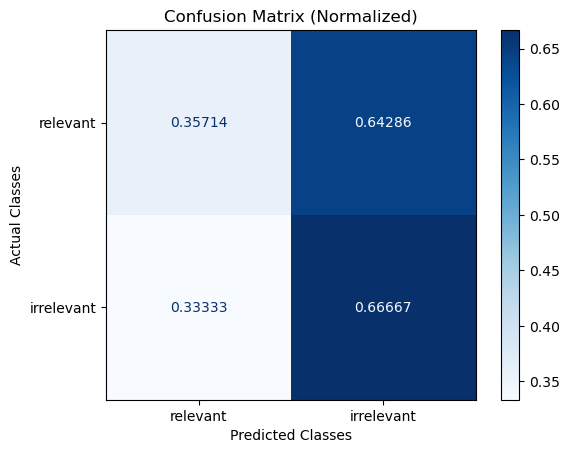

In [18]:
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

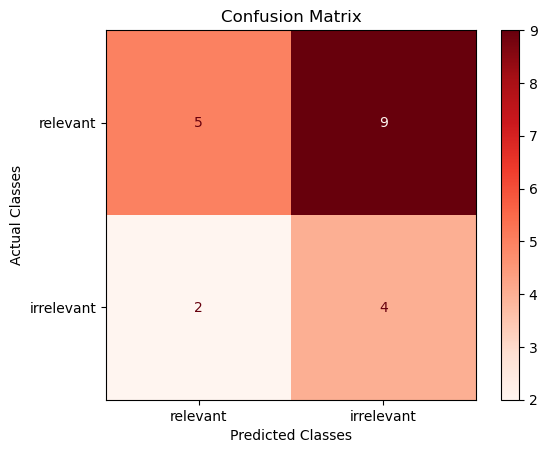

In [19]:
confusion_matrix.plot(
    cmap=plt.colormaps["Reds"],
    number_label=True,
    normalized=False,
)